# Hopfield network of pattern recognition

Hopfield networks are a kind of recurrent neural network that model auto-associative memory: the ability to recall a memory from just a partial piece of that memory.

In [1]:
import os
import numpy as np
import imageio
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
# from skimage import img_as_ubyte

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

np.random.seed(1)

Let's load in a meme. I'm partial to ['Deal with it'](https://a1.memecaptain.com/src_thumbs/22990.jpg).

In [2]:
# deal = imread('small-deal-with-it-with-text.jpg', mode="L")
deal = imageio.imread('small-deal-with-it-with-text.jpg')
print(deal.shape)
deal = deal.astype(int)

(128, 128)


In [3]:
np.unique(deal)

Array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 18

To convert this to a 1 bit image, I convert everything darker than some threshold to black (1), and everything else to white (-1). Experimenting a bit with the particular image of the 'deal with it meme' that I have, a threshold of 80 seemed to work reasonably. The resulting image is still a bit rough around the edges, but it's recognizable.

In [4]:
bvw_threshold = 80

deal[deal <= bvw_threshold] = -1
deal[deal >  bvw_threshold] = 1
deal = -deal
deal

Array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [5]:
np.unique(deal)

Array([-1,  1])

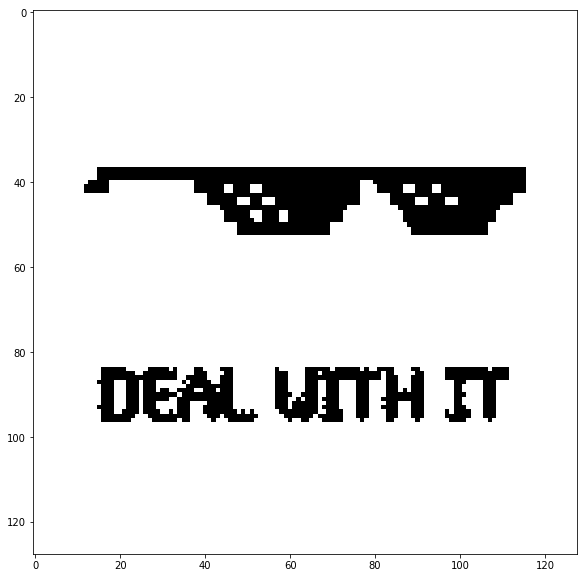

In [6]:
plt.imshow(deal, cmap='Greys', interpolation='nearest')
plt.show()

Now make weights. **For now, we'll use the Hebbian learning rule**, whereby two units have a positive weight (+1) if their activation is the same, and a negative weight (-1) if their activations are differnet. We also stipulate that a neuron have no weight with itself.

In [7]:
flattened_deal = deal.flatten()
flattened_deal.shape

(16384,)

**This next cell can take a little while if the image is large...**

In [8]:
flatlen = len(flattened_deal)

deal_weights = np.outer(flattened_deal,flattened_deal) - np.identity(len(flattened_deal))
deal_weights[:5,:5]

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0.]])

Now start with a noisy version of the image. We'll just flip a certain number of random pixels on each row of the image.

In [9]:
def noisify(pattern, numb_flipped=30):

    noisy_pattern = pattern.copy()

    for idx, row in enumerate(noisy_pattern):
        choices = np.random.choice(range(len(row)), numb_flipped)
        noisy_pattern[idx,choices] = -noisy_pattern[idx,choices]
        
    return noisy_pattern

noisy_deal = noisify(pattern=deal)

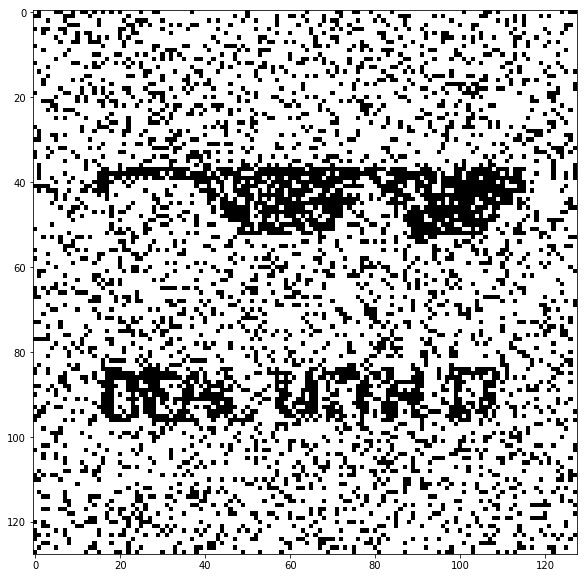

In [10]:
plt.imshow(noisy_deal, cmap='Greys', interpolation='nearest')
plt.show()

Now we can start with that, and use the weights to update it. We'll update the units asynchronously (one at a time).

While we update the units, let's keep track of the **energy** in the network:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/76ad57f7823ca1b74ab67b5f3dadbc83d24da7c2)

Updating the units' activations causes the network to move toward a local minimum in that function. Put more informally, updating the units puts the network a more 'relaxed' state.

Efficient numpy matrix math for computing the energy taken from [here](https://codeaffectionate.blogspot.com/2013/05/fun-with-hopfield-and-numpy.html).

In [11]:
def flow(pattern, weights, theta=0, steps = 50000):
    
    pattern_flat = pattern.flatten()
    
    if (type(theta) == float) or (type(theta) == int):
        thetas = np.zeros(len(pattern_flat)) + theta

    for step in range(steps):
        unit = np.random.randint(low=0, high=(len(pattern_flat)-1))
        unit_weights = weights[unit,:]
        net_input = np.dot(unit_weights,pattern_flat)
        pattern_flat[unit] = 1 if (net_input > thetas[unit]) else -1
        
        if (step % 10000) == 0:
            energy = -0.5*np.dot(np.dot(pattern_flat.T,weights),pattern_flat) + np.dot(thetas,pattern_flat)
            print("Energy at step {:05d} is now {}".format(step,energy))
            
    evolved_pattern = np.reshape(a=pattern_flat, newshape=(pattern.shape[0],pattern.shape[1]))
    
    return evolved_pattern

In [12]:
steps = 50000
theta = 0

noisy_deal_evolved = flow(noisy_deal, deal_weights, theta = theta, steps = steps)

Energy at step 00000 is now -45631266.0
Energy at step 10000 is now -79901890.0
Energy at step 20000 is now -101922450.0
Energy at step 30000 is now -116761570.0
Energy at step 40000 is now -124432896.0


As expected, energy decreases as the units' activations are updated. Now plot the 'evolved' pattern.

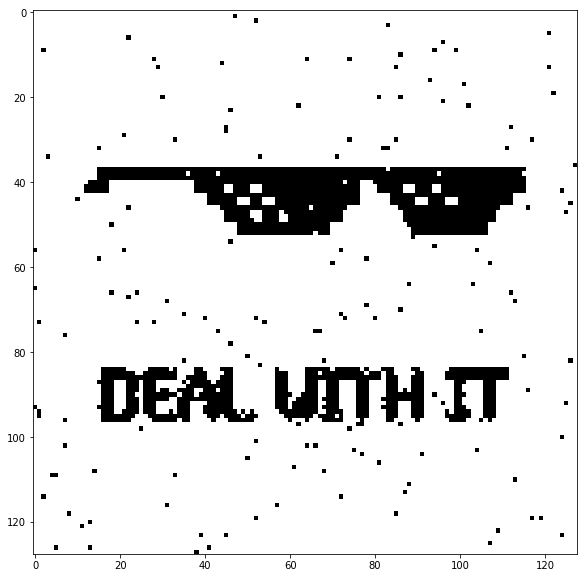

In [13]:
plt.imshow(noisy_deal_evolved, cmap='Greys', interpolation='nearest')
plt.show()

Voila.

## Training the network on a second pattern

The cooler thing about the Hopfield networks is that they can encode multiple patterns (to a limit depending on the training regimen, and the number of units). So let's try another maymay.

I got the next meme from [here](https://68.media.tumblr.com/avatar_0f24a9a67d83_128.png), and then tweaked its levels in Mac's preview so that it'd translate nicely to a 1 bit (black or white) image.

In [14]:
# woah = imread('woah.png', mode="L")
woah = imageio.imread('woah.png')
woah = woah.astype(int)
woah[woah >= 1] = 1
woah[woah < 1] = -1
woah = -woah

In [15]:
np.unique(woah)

Array([-1,  1])

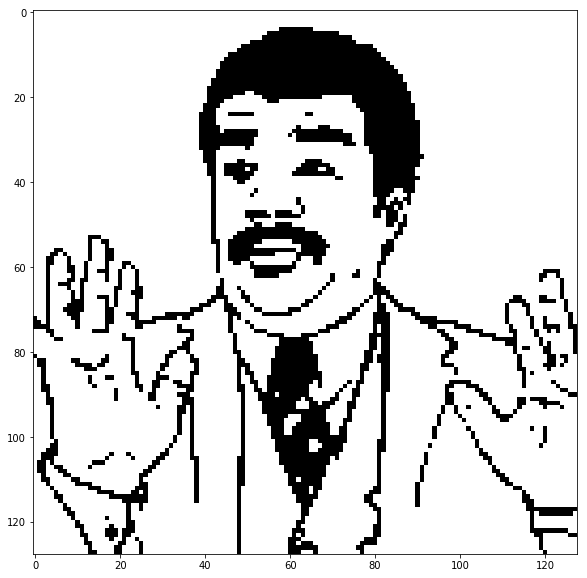

In [16]:
plt.imshow(woah, cmap='Greys', interpolation='nearest')
plt.show()

Cool. So now we make some weights for this image...

In [17]:
flattened_woah = woah.flatten()

flatlen = len(flattened_woah)

woah_weights = np.outer(flattened_woah,flattened_woah) - np.identity(len(flattened_woah))

...and then just average those with the weights for the 'deal with it' network. This takes a surprisingly long time (10-15 seconds).

In [18]:
average_weights = (woah_weights + deal_weights) / 2

Now, let's make a noisy Neil deGrasse Tyson, and have the network try to recover the clean, pristine NGT.

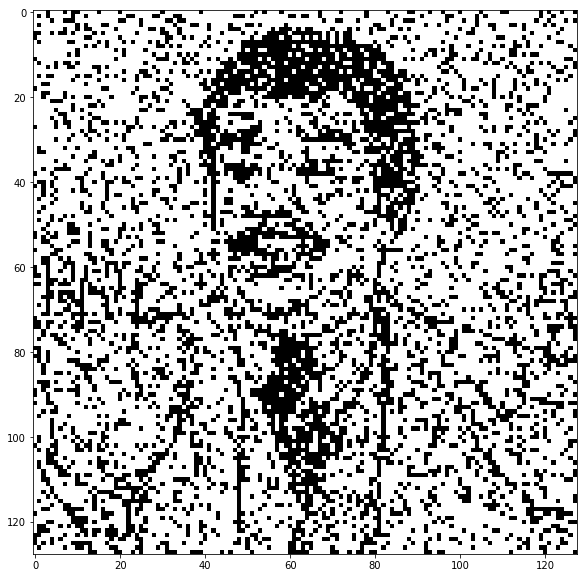

In [19]:
noisy_woah = noisify(pattern=woah)
        
plt.imshow(noisy_woah, cmap='Greys', interpolation='nearest')
plt.show()

Energy at step 00000 is now -28765821.0
Energy at step 10000 is now -51436533.0
Energy at step 20000 is now -65367113.0
Energy at step 30000 is now -73687313.0
Energy at step 40000 is now -78738593.0


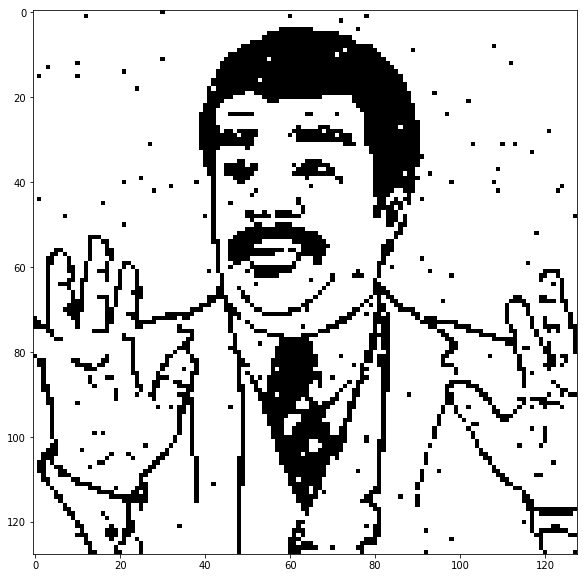

In [20]:
recovered_woah = flow(noisy_woah, average_weights, theta = theta, steps = steps)

plt.imshow(recovered_woah, cmap='Greys', interpolation='nearest')
plt.show()

Now let's doublecheck that the average weights also still work for the 'deal with it' image.

Energy at step 00000 is now -28672913.0
Energy at step 10000 is now -50887029.0
Energy at step 20000 is now -64494945.0
Energy at step 30000 is now -74135093.0
Energy at step 40000 is now -79003753.0


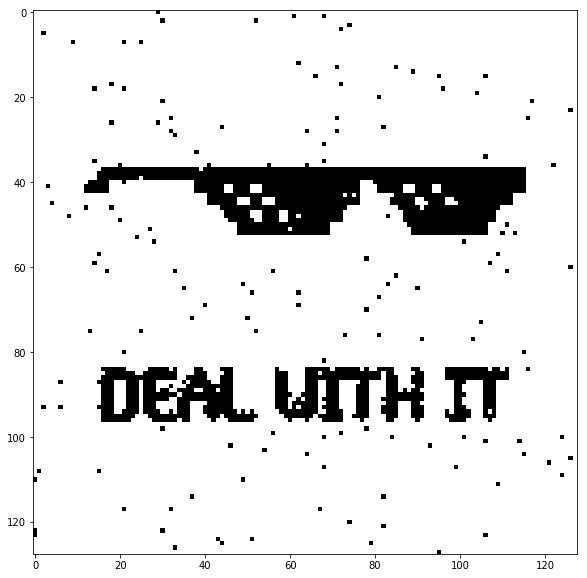

In [21]:
deal_recovered = flow(noisy_deal, average_weights, theta = theta, steps = steps)

plt.imshow(deal_recovered, cmap='Greys', interpolation='nearest')
plt.show()

Sweet. So *now* we can try something like feeding it a pattern that is halfway between the two patterns -- it should eventually settle into one of them! Who has greater meme strength!??!

In [22]:
deal_with_neil = (woah + deal) / 2
print(np.unique(deal_with_neil))

[-1.  0.  1.]


I could force those 0 values to -1 or 1, but that biases the pattern towards deal and neil, respectively (at least, testing suggested this -- I think because Neil has more black pixels and Deal has more white pixels). So, I'll leave them in. I *could* probably solve this by randomly setting 0's to 1 or -1, but naw.

In [23]:
#deal_with_neil[deal_with_neil == 0] = -1
#np.unique(deal_with_neil)

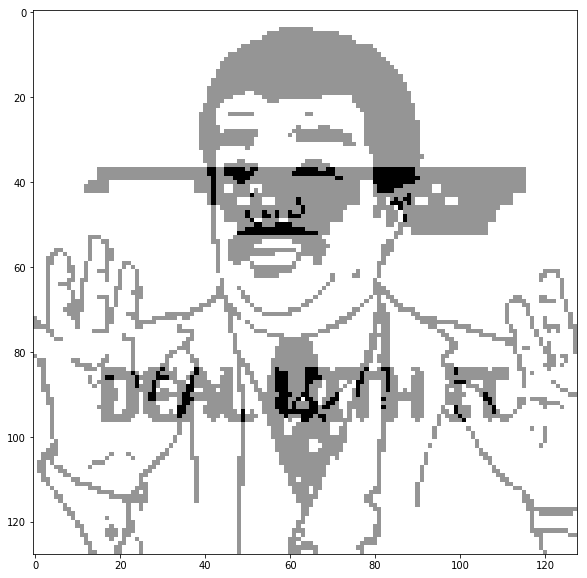

In [24]:
plt.imshow(deal_with_neil, cmap='Greys', interpolation='nearest')
plt.show()

Energy at step 00000 is now -76762245.0
Energy at step 10000 is now -78519120.0
Energy at step 20000 is now -80885001.0
Energy at step 30000 is now -82439010.0
Energy at step 40000 is now -83348880.0


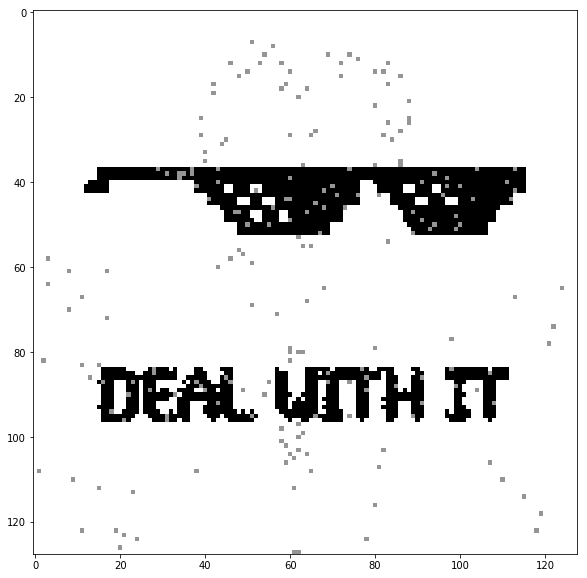

In [25]:
recovered_deal_with_neil = flow(deal_with_neil, average_weights, theta = theta, steps = steps)

plt.imshow(recovered_deal_with_neil, cmap='Greys', interpolation='nearest')
plt.show()

*Assuming the cells/pixels of 0 were unaltered*, if you run that a few times, you'll notice that sometimes it settles on Neil, and sometimes it settles on Deal!!!

## Spurious patterns

Hopfield networks can also settle onto 'spurious patterns' (patterns that the network wasn't trained on). For each stored pattern `x`, `-x` is a spurious pattern. But also, any linear combination of the of the learned patterns can be a spurious pattern. So let's learn a third pattern, and then see the network stabilize on a simple combination of the three patterns.

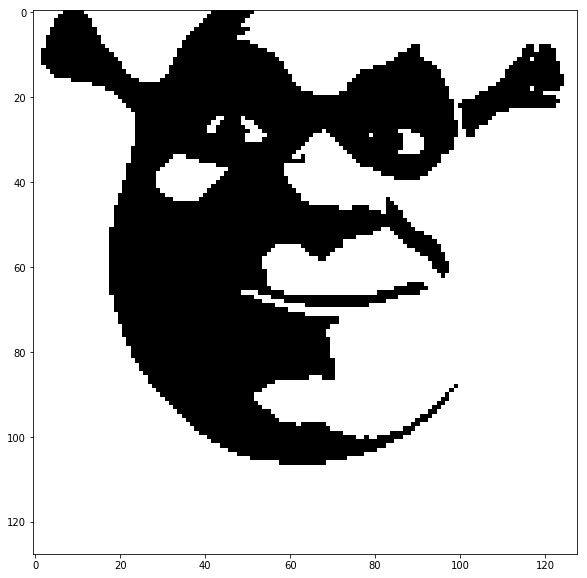

In [26]:
shrek = imageio.imread('shrek.jpg')
shrek = shrek.astype(int)

shrek_threshold = 200
shrek[shrek <  shrek_threshold] = -1
shrek[shrek >= shrek_threshold] = 1

shrek[120:,:] = 1

shrek = -shrek

plt.imshow(shrek, cmap='Greys', interpolation='nearest')
plt.show()

In [27]:
flattened_shrek = shrek.flatten()

flatlen = len(flattened_shrek)

shrek_weights = np.outer(flattened_shrek,flattened_shrek) - np.identity(len(flattened_shrek))

In [28]:
average_weights = (woah_weights + deal_weights + shrek_weights) / 3

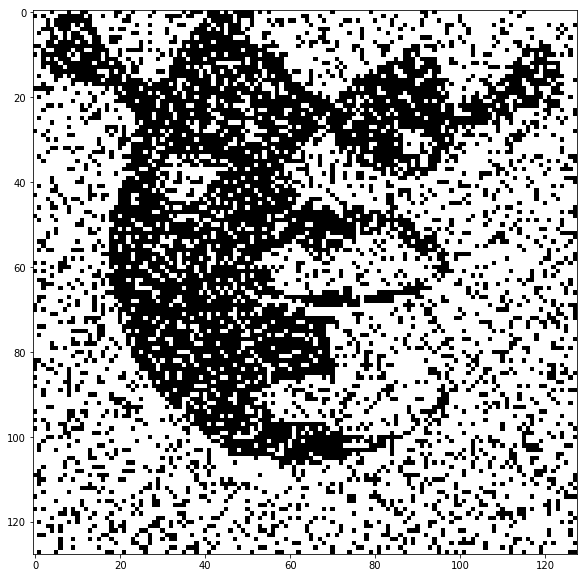

In [29]:
noisy_shrek = noisify(pattern=shrek)
        
plt.imshow(noisy_shrek, cmap='Greys', interpolation='nearest')
plt.show()

Energy at step 00000 is now -18068253.99999998
Energy at step 10000 is now -31821891.999999955
Energy at step 20000 is now -41341803.99999988
Energy at step 30000 is now -47167989.999999814
Energy at step 40000 is now -49923307.333333015


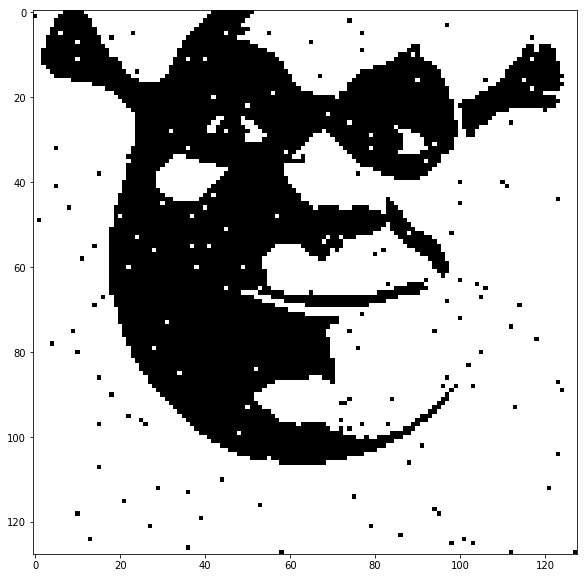

In [30]:
recovered_shrek = flow(noisy_shrek, average_weights, theta=theta, steps=steps)

plt.imshow(recovered_shrek, cmap='Greys', interpolation='nearest')
plt.show()

Energy at step 00000 is now -20881150.00000003
Energy at step 10000 is now -36707755.33333337
Energy at step 20000 is now -47516109.99999988
Energy at step 30000 is now -53669355.333332926
Energy at step 40000 is now -57124227.33333281


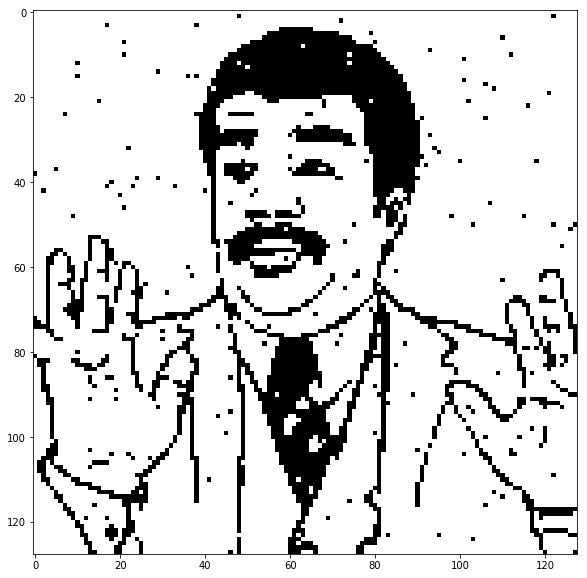

In [31]:
recovered_woah = flow(noisy_woah, average_weights, theta=theta, steps=steps)

plt.imshow(recovered_woah, cmap='Greys', interpolation='nearest')
plt.show()

Okay, now let's make a spurious pattern. Any linear combination will do.

In [32]:
spurious_meme = shrek + deal + woah
np.unique(spurious_meme)

Array([-3, -1,  1,  3])

In [33]:
spurious_meme[spurious_meme > 0] = 1
spurious_meme[spurious_meme < 0] = -1

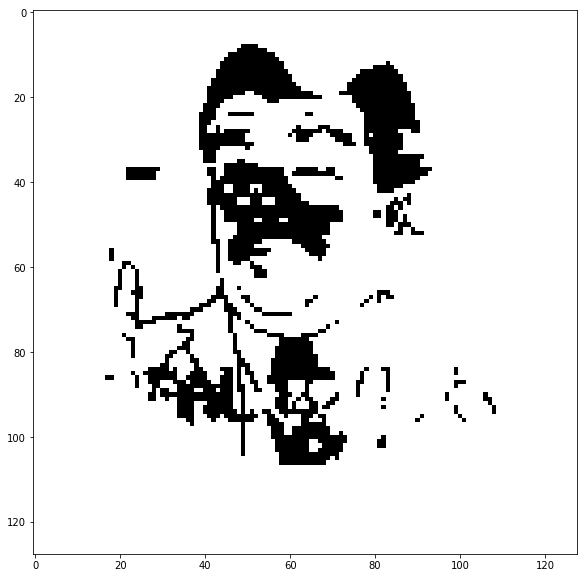

In [34]:
plt.imshow(spurious_meme, cmap='Greys', interpolation='nearest')
plt.show()

Pretty noisy. Only Neal, and kiiiiinda the Deal with It, are visible. Now make a noisy version of that combination.

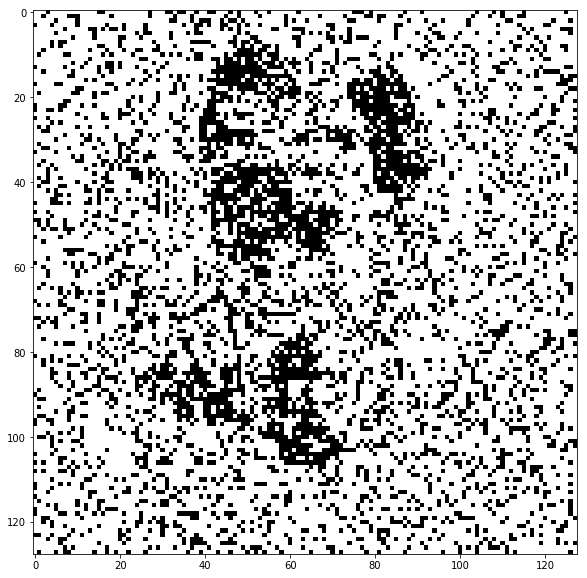

In [35]:
noisy_spurious_meme = noisify(pattern=spurious_meme)
        
plt.imshow(noisy_spurious_meme, cmap='Greys', interpolation='nearest')
plt.show()

Beautifully noisy. Can barely see anything in it. But now if we start with that, and apply the weights, it should recover the spurious pattern!

Energy at step 00000 is now -22167638.66666662
Energy at step 10000 is now -38853437.99999982
Energy at step 20000 is now -49577861.99999981
Energy at step 30000 is now -56643462.66666629
Energy at step 40000 is now -60868803.33333297
Energy at step 50000 is now -62986841.33333297
Energy at step 60000 is now -64089337.33333294
Energy at step 70000 is now -64510675.99999968
Energy at step 80000 is now -64788477.999999605
Energy at step 90000 is now -64942889.33333305


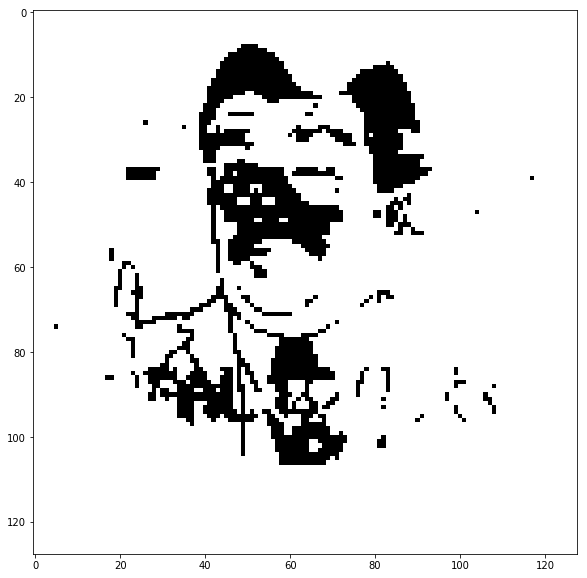

In [36]:
steps = 100000

recovered_spurious_meme = flow(noisy_spurious_meme, average_weights, theta=theta, steps=steps)

plt.imshow(recovered_spurious_meme, cmap='Greys', interpolation='nearest')
plt.show()

And it sure as heck did.

## Animations

Let's make some nifty animations of the networks recovering a pattern (learned or spurious) from an input. Let's make the input more or less pure noise, by increasing `numb_flipped`.

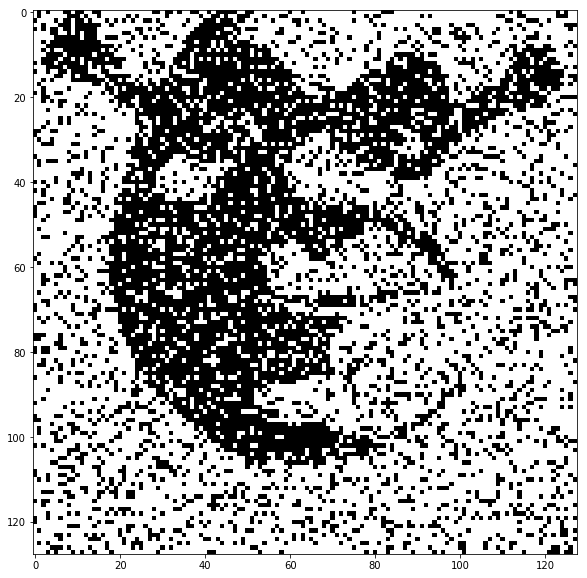

In [37]:
noise = noisify(pattern=shrek, numb_flipped=30)

plt.imshow(noise, cmap='Greys', interpolation='nearest')
plt.show()

Energy at step 00000 is now -18179173.999999985
Energy at step 10000 is now -31717787.3333333
Energy at step 20000 is now -41048675.99999977
Energy at step 30000 is now -46530611.33333314
Energy at step 40000 is now -49546427.33333309


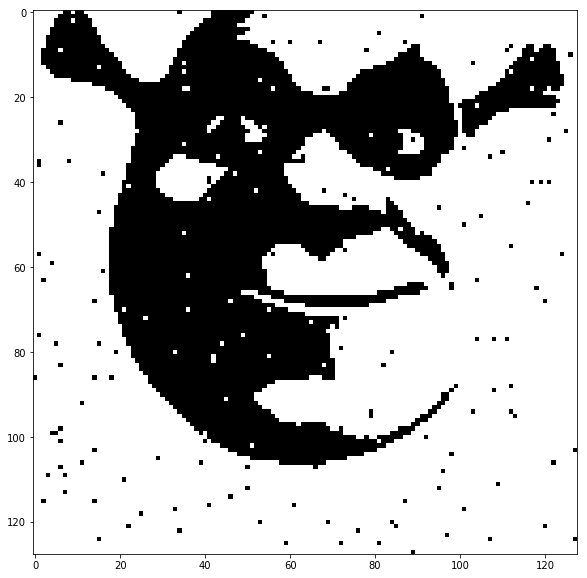

In [38]:
steps = 50000

recovered_meme = flow(noise, average_weights, theta=theta, steps=steps)

plt.imshow(recovered_meme, cmap='Greys', interpolation='nearest')
plt.show()

In [39]:
steps = 50000
noisy_meme_flat = noise.flatten()

for step in range(steps):
    unit = np.random.randint(low=0, high=(len(noisy_meme_flat)-1))
    unit_weights = average_weights[unit,:]
    net_input = np.dot(unit_weights,noisy_meme_flat)

    noisy_meme_flat[unit] = 1 if (net_input > theta) else -1

    recovered_meme = np.reshape(a=noisy_meme_flat, newshape=(len(shrek),len(shrek)))
    if not (step % 1000):
        imageio.imsave('recovery_steps/shrek/recovered_meme{:05d}.jpg'.format(step), recovered_meme.astype(np.uint8))

In [40]:
filenames = sorted([x for x in os.listdir('recovery_steps/shrek') if x[-4:] == '.jpg'])
images = []
for filename in filenames:
    images.append(imageio.imread('recovery_steps/shrek/'+filename))
imageio.mimsave('recovery_steps/shrek/meme_movie.gif', images, duration=0.2)

<img src="meme_movie.gif" alt="Drawing" style="width: 400px;"/>

<img src="recovery_steps/shrek/meme_movie.gif" alt="Drawing" style="width: 400px;"/>